In [15]:
# image segmentation
import os
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.exposure import equalize_adapthist

In [16]:
def normalize(img):
    img_cop  = img.copy()
    img_cop  = img_cop.astype('float64') 
    img_min  = np.min(img_cop)
    img_max  = np.max(img_cop)
    img_cop  = (img_cop - img_min)/(img_max - img_min)
    return img_cop

def save(filename, *args):
    # Get global dictionary
    glob = globals()
    d = {}
    for v in args:
        # Copy over desired values
        d[v] = glob[v]
    with open(filename, 'wb') as f:
        # Put them in the file 
        pickle.dump(d, f)

In [17]:
images_path = 'images/'
masks_path  = 'masks/'
edges_path  = 'edges/'

In [18]:
images_paths = sorted(
    [os.path.join(images_path, fname)
     for fname in os.listdir(images_path)
     if fname.endswith(".png")]
)

masks_paths = sorted(
    [os.path.join(masks_path, fname)
     for fname in os.listdir(masks_path)
     if fname.endswith(".png") and not fname.startswith(".")]
)

edges_paths = sorted(
    [os.path.join(edges_path, fname)
     for fname in os.listdir(edges_path)
     if fname.endswith(".png") and not fname.startswith(".")]
)

train_images_paths = images_paths
train_masks_paths  = masks_paths
train_edges_paths  = edges_paths

img_height    = 256
img_width     = 256
img_channels  = 3

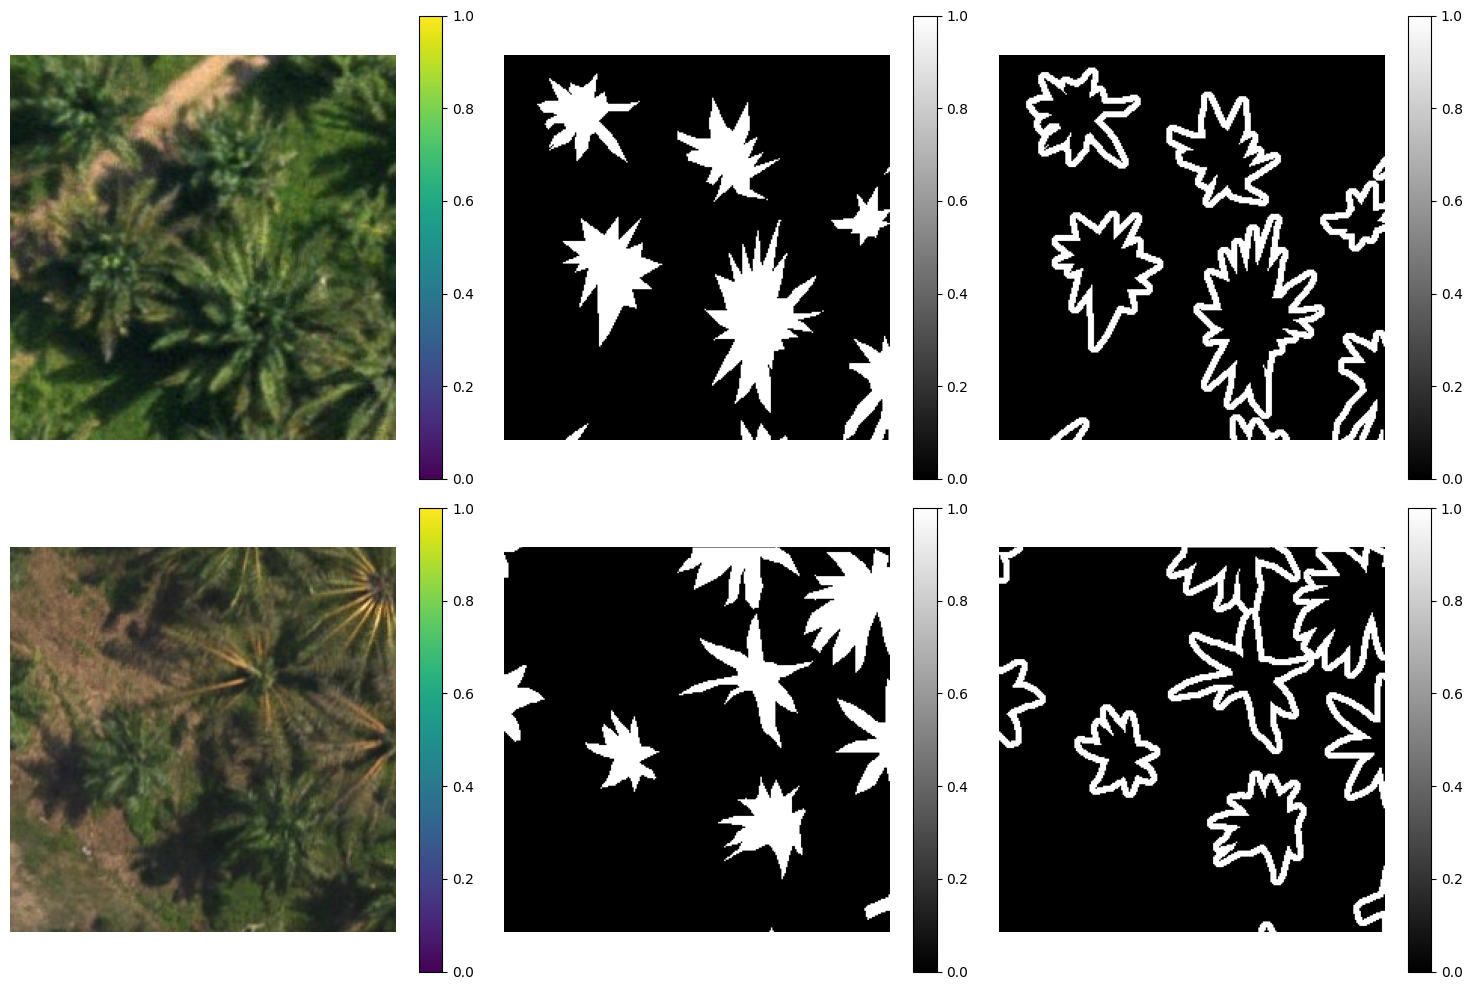

In [20]:
X_train = np.zeros((len(train_images_paths), img_height, img_width, img_channels), dtype= 'float32')
Y_train = np.zeros((len(train_masks_paths), img_height, img_width, 1), dtype = np.bool_)
Y_train_2 = np.zeros((len(train_edges_paths), img_height, img_width, 1), dtype = np.bool_)

for i in range(len(train_images_paths)):   
    img = imread(train_images_paths[i])[:,:,:img_channels] 
    img = normalize(img)
    X_train[i] = img  #Fill empty X_train with values from img

    
for i in range(len(train_masks_paths)):   
    img = imread(train_masks_paths[i])[:,:,0] 
    img = (img > np.max(np.unique(img))/2).astype(np.bool_)
    img = np.expand_dims(img, axis=2)
    Y_train[i] = img  #Fill empty Y_train with values from img 

for i in range(len(train_edges_paths)):   
    img = imread(train_edges_paths[i])[:,:,0] 
    img = (img > np.max(np.unique(img))/2).astype(np.bool_)
    img = np.expand_dims(img, axis=2)
    Y_train_2[i] = img  #Fill empty Y_train with values from img 

# Show trainning images
fig, axs = plt.subplots(2,3, figsize = (15, 10))

h1 = axs[0, 0].imshow(X_train[0])
plt.colorbar(h1, ax = axs[0, 0])
axs[0, 0].axis('off')

h2 = axs[0, 1].imshow(Y_train[0], cmap = 'gray')
plt.colorbar(h2, ax = axs[0, 1])
axs[0, 1].axis('off')

h3 = axs[0, 2].imshow(Y_train_2[0], cmap = 'gray')
plt.colorbar(h3, ax = axs[0, 2])
axs[0, 2].axis('off')

h4 = axs[1, 0].imshow(X_train[1])
plt.colorbar(h4, ax = axs[1, 0])
axs[1, 0].axis('off')

h5 = axs[1, 1].imshow(Y_train[1], cmap = 'gray')
plt.colorbar(h5, ax = axs[1, 1])
axs[1, 1].axis('off')

h6 = axs[1, 2].imshow(Y_train_2[1], cmap = 'gray')
plt.colorbar(h5, ax = axs[1, 2])
axs[1, 2].axis('off')

fig.tight_layout()
plt.show()

In [11]:
#Build the model
inputs = tf.keras.layers.Input((img_height, img_width, img_channels))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

out_mask = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='mask')(c9)
out_edge = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='edge')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[out_mask,out_edge])
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
#callbacks


results = model.fit(X_train, [Y_train, Y_train_2],
                    validation_split = 0.1,
                    epochs           = 20)

Epoch 1/20
27/27 [==============================] - 216s 8s/step - loss: 0.7783 - mask_loss: 0.4006 - edge_loss: 0.3777 - mask_accuracy: 0.8986 - edge_accuracy: 0.9093 - val_loss: 0.6999 - val_mask_loss: 0.3626 - val_edge_loss: 0.3372 - val_mask_accuracy: 0.8929 - val_edge_accuracy: 0.9059
Epoch 2/20
27/27 [==============================] - 214s 8s/step - loss: 0.6533 - mask_loss: 0.3350 - edge_loss: 0.3183 - mask_accuracy: 0.9028 - edge_accuracy: 0.9117 - val_loss: 0.6722 - val_mask_loss: 0.3467 - val_edge_loss: 0.3255 - val_mask_accuracy: 0.8929 - val_edge_accuracy: 0.9059
Epoch 3/20
27/27 [==============================] - 213s 8s/step - loss: 0.6097 - mask_loss: 0.3097 - edge_loss: 0.3000 - mask_accuracy: 0.9028 - edge_accuracy: 0.9117 - val_loss: 0.6764 - val_mask_loss: 0.3387 - val_edge_loss: 0.3377 - val_mask_accuracy: 0.8929 - val_edge_accuracy: 0.9059
Epoch 4/20
27/27 [==============================] - 211s 8s/step - loss: 0.5427 - mask_loss: 0.2600 - edge_loss: 0.2827 - mask_

In [13]:
model.save('model_segmentation.keras')

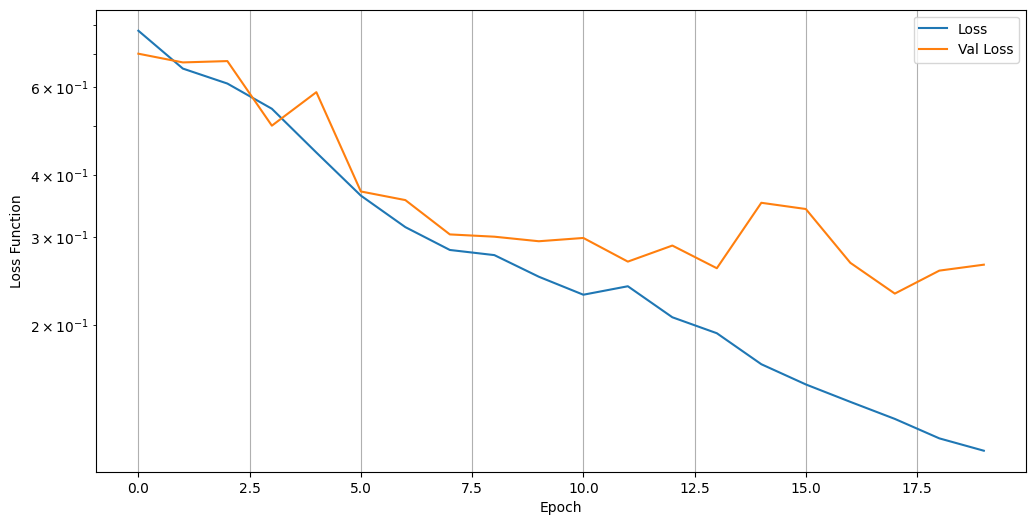

In [14]:
plt.figure(figsize=(12,6))
plt.semilogy(results.history['loss'], label = 'Loss')
plt.semilogy(results.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()
plt.grid('on')
plt.show()